In [ ]:
## Import basic libraries 

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
## Import raw data
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/univariate_data.csv') # Insert path of data
df_raw


,Time,rgdp
0,1980 Q1,232982
1,1980 Q2,228337
2,1980 Q3,228108
3,1980 Q4,225615
4,1981 Q1,225484
...,...,...
155,2018 Q4,538222
156,2019 Q1,541195
157,2019 Q2,541944
158,2019 Q3,544639


In [ ]:
## Convert the format of Time
df_raw['Time'] = pd.Series(df_raw['Time'], dtype='string')
df_raw['Time'] = df_raw['Time'].str.replace(' ','') 
df_raw.Year = pd.to_datetime(df_raw['Time'])
df_raw['Time'] = pd.PeriodIndex(df_raw.Year, freq='Q').to_timestamp()
df_raw['Time'] = df_raw['Time'] + pd.offsets.QuarterEnd(0)

# # Set Time as index of data frame
df_raw= df_raw.set_index('Time')
df_raw.head()

,rgdp
Time,
1980-03-31,232982
1980-06-30,228337
1980-09-30,228108
1980-12-31,225615
1981-03-31,225484


In [ ]:
## Transform the real GDP to GDP Growth by taking the first difference of log scale.
df_raw['gr_gdp'] = np.log(df_raw['rgdp']).diff(1)
df_trans = df_raw[['gr_gdp' ]].dropna() # Drop the row which contains missing values.
df_trans.head()

,gr_gdp
Time,
1980-06-30,-0.020139
1980-09-30,-0.001003
1980-12-31,-0.010989
1981-03-31,-0.000581
1981-06-30,0.002312


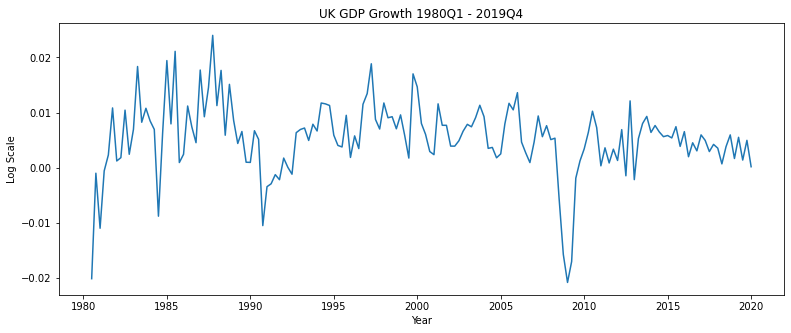

<Figure size 432x288 with 0 Axes>

In [ ]:
## Data visuallization
plt.figure(figsize=(13, 5))
plt.plot(df_trans['gr_gdp'])
plt.title('UK GDP Growth 1980Q1 - 2019Q4' )
plt.xlabel('Year')
plt.ylabel('Log Scale')
plt.show()
plt.savefig('Gr_uni.svg')

In [ ]:
## Test the stationary of GDP Growth

# Import the ADF function
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test in which the hypothesis H0: a unit root is present in time series; H1: no unit root exists
result = adfuller(df_trans['gr_gdp'],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Number of Lags Used:{result[2]}')
print(f'Number of Observations Used:{result[3]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

#Since p-value<0.05 and ADF Statistic < Critical Value => reject H0  => data is stationary

In [ ]:
## Convert time series into supervised learning problems. 

# Lags up to 4 of GDP Growth are used as features. 
df_trans['lag_1'] = df_trans['gr_gdp'].shift(1)
df_trans['lag_2'] = df_trans['gr_gdp'].shift(2)
df_trans['lag_3'] = df_trans['gr_gdp'].shift(3)
df_trans['lag_4'] = df_trans['gr_gdp'].shift(4)
df_trans = df_trans[['lag_4','lag_3','lag_2','lag_1','gr_gdp']]
df_trans.head()

In [ ]:
## Split the data with train/test ratio of 70/30:  70% for training and 30% for testing
# Hide this cell in the case of train/test 80/20

# df1:training data -> used for tuning hyperparameter and training the model
df1 = df_trans.iloc[0:round(0.7*len(df_trans['gr_gdp'])),:]

# df2: testing data -> used for perfoming out-of-sample forecasts
df2 = df_trans.iloc[round(0.7*len(df_trans['gr_gdp'])):len(df_trans['gr_gdp']) ,:]



In [ ]:
# ## Split the data with train/test ratio of 80/20:  80% for training and 20% for testing
# # Hide this cell in the case of train/test 70/30

# # df1:training data -> used for tuning hyperparameter and training the model
# df1 = df_trans.iloc[0:round(0.8*len(df_trans['gr_gdp'])),:]

# # df2: testing data -> used for perfoming out-of-sample forecasts
# df2 = df_trans.iloc[round(0.8*len(df_trans['gr_gdp'])):len(df_trans['gr_gdp']) ,:]


In [ ]:
## Create the feature subsets 

featuresubsets=['lag_1', ('lag_2', 'lag_1'),  ('lag_3', 'lag_2', 'lag_1'), ('lag_4', 'lag_3', 'lag_2', 'lag_1')]
featuresubsets

In [ ]:
## Perfom the Grid Search with 10-fold Cross-validation to tun the hyperparameters

# Import libraries and function for modelling

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from math import sqrt
import statistics

# Create a list to store the resulst of Gridsearch CV

FeatureNames = []
NumberOfFeatures = []
NumberOfNeighbors = []
WeightingScheme = []
DistanceMetric = []
ValidationAccuracy = []

# Separate the features and target values

X = df1.iloc[:,:-1]
Y = df1['gr_gdp']


# GRID SEARCH ALGORITHM

# loop throughs all feature subset
for num in range(0,len(featuresubsets)):
    # modify X by Xnew so that it includes only the selected feature subsets
    if type(featuresubsets[num]) == str:
        XNew = X[[featuresubsets[num]]].dropna()
    else:
        XNew = X[list(featuresubsets[num])].dropna()
        
    # For each feature subsets, create models with every values of K from 1 to 12. 
    for K in range(1,12):
        # For each combination of feature subsets and K, create models with different combinations of weighting schemes and distance metrics
        for weight in ['uniform', 'distance']:
            for distance in ['euclidean','manhattan']:
              
                model = KNeighborsRegressor(n_neighbors = K, weights = weight , metric = distance)
                
                # Creat a list to store the training/validation score of every iteration through Cross-validation process
                modeltrain = []
                modeltest = []
                
                # Perform the 10-folds cross-validation process, then store all training/validation scores of each iterations.
                cv = KFold(n_splits = 10,shuffle=True, random_state=123)
          
                for train,test in cv.split(XNew):
                    
                    xtrain,xtest,ytrain,ytest = XNew.iloc[train],XNew.iloc[test],Y.iloc[train],Y.iloc[test]
                    model.fit(xtrain,ytrain)
                    modeltest.append(model.score(xtest,ytest))
                    
                # Store the values of hyperparameters
                FeatureNames.append(featuresubsets[num])
                NumberOfFeatures.append(len(XNew.columns))
                NumberOfNeighbors.append(K)
                WeightingScheme.append(weight)
                DistanceMetric.append(distance)
                ValidationAccuracy.append(statistics.mean(modeltest)) # Take average validation score of all iterations of each model
              
# Create a summary report of Grid Search with 10-fold CV, then return the top 10 models with highest validation score. 
SummaryReport = pd.DataFrame()
SummaryReport['Feature Names'] = FeatureNames
SummaryReport['Number of Features'] = NumberOfFeatures
SummaryReport['Number of Neighbors K'] = NumberOfNeighbors
SummaryReport['Weighting Scheme'] = WeightingScheme
SummaryReport['Distance Metric'] = DistanceMetric
SummaryReport['Validation Accuracy'] = ValidationAccuracy
SummaryReport.sort_values('Validation Accuracy', ascending=False,inplace=True)
SummaryReport = SummaryReport.head(10)
SummaryReport.set_index('Feature Names',inplace = True)
SummaryReport



In [ ]:
uni_8020_cv = SummaryReport.to_csv('/content/drive/MyDrive/Colab Notebooks/uni_8020_cv.csv') 

In [ ]:
## Create data for prediction based on the feature selection above

# Training data
df_train = df1[['lag_1','gr_gdp']].dropna()

# Testing data
df_test = df2[['lag_1','gr_gdp']].dropna()


In [ ]:
## Perform out-of-sample forecast for one-step-ahead using KNN regression

# Import the accuracy metrics 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Create features and targets as input and output for training phase
X_train = df_train.iloc[:,:-1]
Y_train = df_train['gr_gdp']

# Create input for prediction, Y_test now is the observed values
X_test = df_test.iloc[:,:-1]
Y_test = df_test['gr_gdp']
    
# Perfom out-of-sample forecast

#Train/test ratio is 70/30 -> Hide this row if train/test ratio is 80/20
KNN = KNeighborsRegressor(n_neighbors = 1, weights = 'uniform', metric = 'euclidean')

# Train/test 80/20 -> Hide this row if train/test ratio is 70/30
# KNN = KNeighborsRegressor(n_neighbors = 4, weights = 'distance', metric = 'manhattan')

knn = KNN.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

# Print the forecast errors

print('MAE: ' + str(np.mean(np.abs(Y_test - Y_pred))))
print('RMSE: ' + str(np.sqrt(mse(Y_test, Y_pred))))

MAE: 0.005848954827993265
RMSE: 0.007811775495746667


In [ ]:
## Create the data frame of results for visualizing a comparision of observed values and predicted values
df3=pd.DataFrame(Y_test)
df3['knn_pred'] = Y_pred.tolist()
df3=df3.sort_index()
df3

In [ ]:
## Plot the forecast comparision between observed values and predicted values in case of train/test 70/30
#Hide this cell in case of train/test 80/20

plt.figure(figsize=(9, 4))
plt.ylim(-0.04,0.04)
plt.plot(df3['gr_gdp'], 'b-', label = 'Actual')
plt.plot(df3['knn_pred'], 'r-', label = 'Predicted')
plt.xlabel('Year')
plt.ylabel('Log Scale')
plt.title('Univariate KNN - Predicted vs. Actual Values (train/test = 70/30)')
plt.legend()
plt.show()

In [ ]:
# ## Plot the forecast comparision between observed values and predicted values in case of train/test 80/20
# #Hide this cell in case of train/test 70/30

# plt.figure(figsize=(9, 4))
# plt.ylim(-0.04,0.04)
# plt.plot(df3['gr_gdp'], 'b-', label = 'Actual')
# plt.plot(df3['knn_pred'], 'r-', label = 'Predicted')
# plt.xlabel('Year')
# plt.ylabel('Log Scale')
# plt.title('Univariate KNN - Predicted vs. Actual Values (train/test = 80/20)')
# plt.legend()
# plt.show()


In [ ]:
!pip install pmdarima

In [ ]:
## Model selection using Auto ARIMA 
# Import functions
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Apply Auto ARIMA
model = pm.auto_arima(Y_train, start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find the optimal value of 'd'
                      max_p=3, max_q=3, # Set 3 as maximum values of p and q
                      m=1,              # Set 1 as frequency of series
                      d=None,           # Value of 'd' will be optimzed automatically
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Show a summary of model
print(model.summary())


In [ ]:
## Add the ARIMA predicted values to the dataframe for comparison
arima_pred = model.predict(n_periods= len(Y_test))
df3["Arima_Pred"] = arima_pred .tolist()
df3=df3.sort_index()
df3

In [ ]:
## Print forecast errors

print('MAE: ' + str(np.mean(np.abs(Y_test - arima_pred))))
print('RMSE: ' + str(np.sqrt(mse(Y_test, arima_pred))))
